## Import and install all required packages and libraries

In [1]:
!pip install patchify
!pip install keras
!pip install imagecodecs
!pip install -U scikit-learn==0.24.2
!pip install pandas
!pip install segmentation-models

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import numpy as np
from matplotlib import pyplot as plt
from patchify import patchify
import tifffile as tiff
import numpy as np
from keras import backend as K
import os
import re
import cv2

## Multi Unet Model

In [3]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

def multi_unet_model(n_classes=5, IMG_HEIGHT=128, IMG_WIDTH=128, IMG_CHANNELS=1):

    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    return model

2022-03-22 19:02:36.658717: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/x86_64-linux-gnu:
2022-03-22 19:02:36.658790: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Choose the Unet Model

In [83]:
MODEL = 'unet_crossentropy'
# MODEL = 'unet_focall_loss'
# MODEL = 'unet_resnet34'

## Train data

In [4]:
train_filenames = []
for subdir, dirs, files in os.walk('./data/train'):
    for file in files:
        filepath = subdir + os.sep + file
        if filepath.endswith(".tiff"):
            
            train_filenames.append(filepath)
            
train_filenames.sort(key=lambda f: int(re.sub('\D', '', f)))    
train_filenames = np.array(train_filenames)

all_img_patches = []

for img_file in train_filenames:  
    large_image = tiff.imread(img_file)
    patches_img = patchify(large_image, (128, 128, 3), step=128)
    
    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):
            
            single_patch_img = patches_img[i,j, 0, :, :, :]
            single_patch_img = (single_patch_img.astype('float32')) / 255.
            
            all_img_patches.append(single_patch_img)

train_images = np.array(all_img_patches)

In [5]:
train_mask_filenames = []
for subdir, dirs, files in os.walk('./data/train_mask'):
    for file in files:
        filepath = subdir + os.sep + file
        if filepath.endswith(".tiff"):
            train_mask_filenames.append(filepath)
            
train_mask_filenames.sort(key=lambda f: int(re.sub('\D', '', f)))    
train_mask_filenames = np.array(train_mask_filenames)          

all_mask_patches = []

for img_file in train_mask_filenames:  
     
    large_mask = tiff.imread(img_file)  
    patches_mask = patchify(large_mask, (128, 128), step=128)  #Step=256 for 256 patches means no overlap
    

    for i in range(patches_mask.shape[0]):
        for j in range(patches_mask.shape[1]):
            single_patch_mask = patches_mask[i,j,:,:]
            all_mask_patches.append(single_patch_mask)

train_masks = np.array(all_mask_patches)

In [6]:
print(train_images.shape)
print(train_masks.shape)
print("Pixel values in the mask are: ", np.unique(train_masks))

(3480, 128, 128, 3)
(3480, 128, 128)
Pixel values in the mask are:  [0 1 2 3 4]


In [7]:
#Encode labels... but multi dim array so need to flatten, encode and reshape
from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder()
print(train_masks.shape)
n, h, w = train_masks.shape

train_masks_reshaped = train_masks.reshape(-1,1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

np.unique(train_masks_encoded_original_shape)

(3480, 128, 128)


/home/mashmallow/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


array([0, 1, 2, 3, 4])

## Test data

In [8]:
test_filenames = []
for subdir, dirs, files in os.walk('./data/test'):
    for file in files:
        filepath = subdir + os.sep + file
        if filepath.endswith(".tiff"):
            test_filenames.append(filepath)
            
test_filenames.sort(key=lambda f: int(re.sub('\D', '', f)))    
test_filenames = np.array(test_filenames)

all_img_patches = []

for img_file in test_filenames:  
    large_image = tiff.imread(img_file)
    #large_image = cv2.imread(img_path, 0)    
    patches_img = patchify(large_image, (128, 128, 3), step=128)
    
    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):
            
            single_patch_img = patches_img[i,j, 0, :, :, :]
            single_patch_img = (single_patch_img.astype('float32')) / 255.
            
            all_img_patches.append(single_patch_img)

test_images = np.array(all_img_patches)

In [9]:
test_mask_filenames = []
for subdir, dirs, files in os.walk('./data/test_mask'):
    for file in files:
        filepath = subdir + os.sep + file
        if filepath.endswith(".tiff"):
            test_mask_filenames.append(filepath)
            
test_mask_filenames.sort(key=lambda f: int(re.sub('\D', '', f)))    
test_mask_filenames = np.array(test_mask_filenames)          

all_mask_patches = []

for img_file in test_mask_filenames:  
    large_mask = tiff.imread(img_file)   
    #large_image = cv2.imread(img_path, 0)    
    patches_mask = patchify(large_mask, (128, 128), step=128)  #Step=256 for 256 patches means no overlap
    

    for i in range(patches_mask.shape[0]):
        for j in range(patches_mask.shape[1]):
            single_patch_mask = patches_mask[i,j,:,:]
            all_mask_patches.append(single_patch_mask)

test_masks = np.array(all_mask_patches)

In [10]:
print(test_images.shape)
print(test_masks.shape)
print("Pixel values in the mask are: ", np.unique(test_masks))

(2280, 128, 128, 3)
(2280, 128, 128)
Pixel values in the mask are:  [0 1 2 3 4]


In [11]:
#Encode labels... but multi dim array so need to flatten, encode and reshape
from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder()
print(train_masks.shape)
n, h, w = train_masks.shape

train_masks_reshaped = train_masks.reshape(-1,1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

np.unique(train_masks_encoded_original_shape)

(3480, 128, 128)


array([0, 1, 2, 3, 4])

In [12]:
from tensorflow.keras.utils import normalize

print(train_images.shape)
#train_images = np.expand_dims(train_images, axis=3)
print(train_images.shape)

train_images = normalize(train_images, axis=1)
print(train_images.shape)

train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)

print(train_masks_input.shape)

(3480, 128, 128, 3)
(3480, 128, 128, 3)
(3480, 128, 128, 3)
(3480, 128, 128, 1)


In [13]:
#Create a subset of data for quick testing
#Picking 10% for testing and remaining for training
from sklearn.model_selection import train_test_split

X1, X_test, y1, y_test = train_test_split(train_images, train_masks_input, test_size = 0.10, random_state = 0)

#Further split training data t a smaller subset for quick testing of models
X_train, X_do_not_use, y_train, y_do_not_use = train_test_split(X1, y1, test_size = 0.2, random_state = 0)

print("Class values in the dataset are ... ", np.unique(y_train))  # 0 is the background/few unlabeled 

Class values in the dataset are ...  [0 1 2 3 4]


In [14]:
print(X_train.shape)

(2505, 128, 128, 3)


2289
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]]


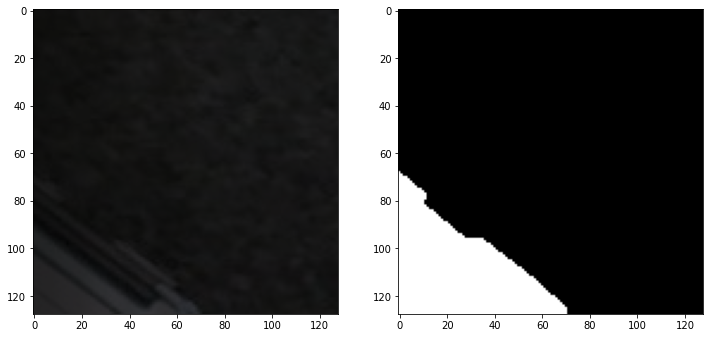

In [15]:
#Sanity check, view few mages
import random
import numpy as np

image_number = random.randint(0, len(X_train))
print(image_number)

plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.imshow(np.reshape(X_train[image_number], (128, 128,3)))
plt.subplot(122)
plt.imshow(np.reshape(y_train[image_number], (128, 128)), cmap='gray')

print(np.reshape(y_train[image_number], (128, 128)))

plt.show()

In [16]:
from tensorflow.keras.utils import to_categorical

n_classes = 5
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))
print(y_train_cat.shape)

test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))
print(y_test_cat.shape)

(2505, 128, 128, 5)
(348, 128, 128, 5)


In [231]:
def categorical_focal_loss(alpha, gamma=2.):
    """
    Softmax version of focal loss.
    When there is a skew between different categories/labels in your data set, you can try to apply this function as a
    loss.
           m
      FL = ∑  -alpha * (1 - p_o,c)^gamma * y_o,c * log(p_o,c)
          c=1
      where m = number of classes, c = class and o = observation
    Parameters:
      alpha -- the same as weighing factor in balanced cross entropy. Alpha is used to specify the weight of different
      categories/labels, the size of the array needs to be consistent with the number of classes.
      gamma -- focusing parameter for modulating factor (1-p)
    Default value:
      gamma -- 2.0 as mentioned in the paper
      alpha -- 0.25 as mentioned in the paper
    References:
        Official paper: https://arxiv.org/pdf/1708.02002.pdf
        https://www.tensorflow.org/api_docs/python/tf/keras/backend/categorical_crossentropy
    Usage:
     model.compile(loss=[categorical_focal_loss(alpha=[[.25, .25, .25]], gamma=2)], metrics=["accuracy"], optimizer=adam)
    """

    alpha = np.array(alpha, dtype=np.float32)

    def categorical_focal_loss_fixed(y_true, y_pred):
        """
        :param y_true: A tensor of the same shape as `y_pred`
        :param y_pred: A tensor resulting from a softmax
        :return: Output tensor.
        """

        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

        cross_entropy = -y_true * K.log(y_pred)

        loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy

        return K.mean(K.sum(loss, axis=-1))

    return categorical_focal_loss_fixed

## Create model

In [82]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

print(X_train.shape)

def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

model = get_model()

def unet_resnet_backbone(BACKBONE, n_classes=5):
    BACKBONE1 = BACKBONE

    # define model
    model = sm.Unet(BACKBONE1, encoder_weights='imagenet', classes=n_classes, activation='softmax')
    return model

if MODEL = 'unet_crossentropy':
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
elif MODEL = 'unet_focall_loss' :
    alpha = [[.25, .25, .25, .25, .25]]
    model.compile(optimizer='adam', loss=categorical_focal_loss(alpha, gamma=.2), metrics=['accuracy'])
else: 
    dice_loss = sm.losses.DiceLoss(class_weights=np.array([0.25, 0.25, 0.25, 0.25, 0.25])) 
    focal_loss = sm.losses.CategoricalFocalLoss()
    total_loss = dice_loss + (1 * focal_loss)

    BACKBONE = 'resnet34'
    preprocess_input1 = sm.get_preprocessing(BACKBONE)
    X_train = preprocess_input1(X_train)
    X_test = preprocess_input1(X_test)
    
    model = unet_resnet_backbone(BACKBONE=BACKBONE, n_classes=5)

model.summary()

(2505, 128, 128, 3)
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 128, 128, 16  448         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_9 (Dropout)            (None, 128, 128, 16  0           ['conv2d_19[0][0]']              
                                )                                       

 conv2d_transpose_7 (Conv2DTran  (None, 128, 128, 16  2064       ['conv2d_34[0][0]']              
 spose)                         )                                                                 
                                                                                                  
 concatenate_7 (Concatenate)    (None, 128, 128, 32  0           ['conv2d_transpose_7[0][0]',     
                                )                                 'conv2d_20[0][0]']              
                                                                                                  
 conv2d_35 (Conv2D)             (None, 128, 128, 16  4624        ['concatenate_7[0][0]']          
                                )                                                                 
                                                                                                  
 dropout_17 (Dropout)           (None, 128, 128, 16  0           ['conv2d_35[0][0]']              
          

## Train model

In [ ]:
#If starting with pre-trained weights. 
#model.load_weights('???.hdf5')
from keras.callbacks import CSVLogger

FILE_MODEL_NAME = MODEL

csv_logger = CSVLogger(f'{FILE_MODEL_NAME}.log', separator=',', append=False)

history = model.fit(X_train, y_train_cat, 
                    batch_size = 8, 
                    verbose=1, 
                    epochs=50, 
                    validation_data=(X_test, y_test_cat), 
                    callbacks=[csv_logger],
                    shuffle=False)

model.save(f'{FILE_MODEL_NAME}.hdf5')


## Load model if one exists

In [24]:
from tensorflow import keras
import segmentation_models as sm


if MODEL = 'unet_crossentropy':
    model.load_weights(f'{FILE_MODEL_NAME}.hdf5')
elif MODEL = 'unet_focall_loss' :
    model.load_weights(f'{FILE_MODEL_NAME}.hdf5')
else: 
    dice_loss = sm.losses.DiceLoss(class_weights=np.array([0.25, 0.25, 0.25, 0.25, 0.25])) 
    focal_loss = sm.losses.CategoricalFocalLoss()
    total_loss = dice_loss + (1 * focal_loss)

    model = keras.models.load_model(f'{FILE_MODEL_NAME}.hdf5', 
                                   custom_objects={'dice_loss_plus_1focal_loss': total_loss})



## Loss and accuracy

In [234]:
_, acc = model.evaluate(X_test, y_test_cat)
print("Accuracy is = ", (acc * 100.0), "%")

11/11 [==============================] - 6s 492ms/step - loss: 0.0086 - accuracy: 0.9802
Accuracy is =  98.02495241165161 %


In [235]:
import pandas as pd
FILE_MODEL_NAME = 'test_50_epochs_8_batch_size_focal_loss'
log_file = 'training_test_50_epochs_8_batch_size_focal_loss.log'
history = pd.read_csv(log_file, sep=r',', header=[0], engine='python')


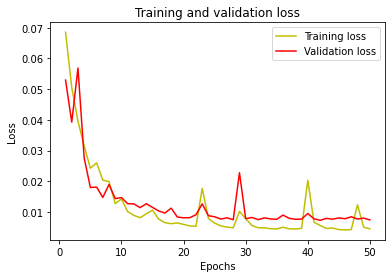

In [236]:
#plot the training and validation accuracy and loss at each epoch
loss = history['loss']
val_loss = history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(f'{FILE_MODEL_NAME}_loss.jpg')
plt.show()


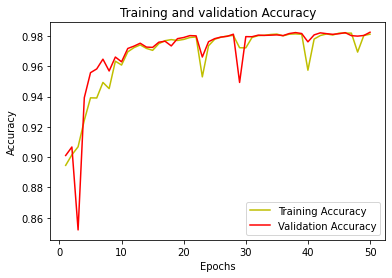

In [237]:
acc = history['accuracy']
val_acc = history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig(f'{FILE_MODEL_NAME}_accuracy.jpg')
plt.show()


## Intersection-Over-Union metric

In [25]:
#IOU
y_pred = model.predict(X_test)
y_pred_argmax = np.argmax(y_pred, axis=3)


##################################################

#Using built in keras function
from keras.metrics import MeanIoU

n_classes = 5
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
meanIoU = IOU_keras.result().numpy()
print("Mean IoU =", meanIoU)


#To calculate I0U for each class...
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3]+ values[0,4] + values[1,0] + values[2,0] + values[3,0] + values[4,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] +values[1, 4] + values[0,1]+ values[2,1]+ values[3,1] + values[4,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] +values[2, 4] + values[0,2]+ values[1,2]+ values[3,2] + values[4,2])
class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] +values[3, 4] + values[0,3]+ values[1,3]+ values[2,3] + values[4,3])
class5_IoU = values[4,4]/(values[4,4] + values[4,0] + values[4,1] + values[4,2] + values[4, 3] + values[0,4]+ values[1,4]+ values[2,4] + values[3,4])


print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)
print("IoU for class4 is: ", class4_IoU)
print("IoU for class5 is: ", class5_IoU)

Mean IoU = 0.7998301
[[5.086111e+06 2.549000e+03 1.708000e+03 4.532000e+03 1.805400e+04]
 [1.223200e+04 1.319540e+05 0.000000e+00 5.240000e+02 3.700000e+01]
 [1.890000e+03 1.762000e+03 1.507400e+04 1.101000e+03 0.000000e+00]
 [1.809000e+03 0.000000e+00 0.000000e+00 2.879820e+05 6.524000e+03]
 [1.778000e+03 2.000000e+00 0.000000e+00 3.807600e+04 8.793300e+04]]
IoU for class1 is:  0.9913165
IoU for class2 is:  0.88524085
IoU for class3 is:  0.6999768
IoU for class4 is:  0.8456429
IoU for class5 is:  0.576973


  Classes       IoU
0  class1  0.991316
1  class2  0.885241
2  class3  0.699977
3  class4  0.845643
4  class5  0.576973


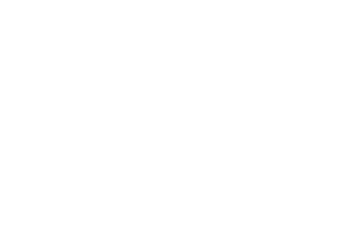

In [26]:
import pandas as pd

ax = plt.subplot(111, frame_on=False) # no visible frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis

data = {
    'Classes':  ['class1', 'class2', 'class3', 'class4', 'class5'],
    'IoU': [class1_IoU,  class2_IoU,  class3_IoU,  class4_IoU,  class5_IoU],
        }

df = pd.DataFrame(data)

print(df)

## Prediction check

Image number 302
(1, 128, 128, 3)


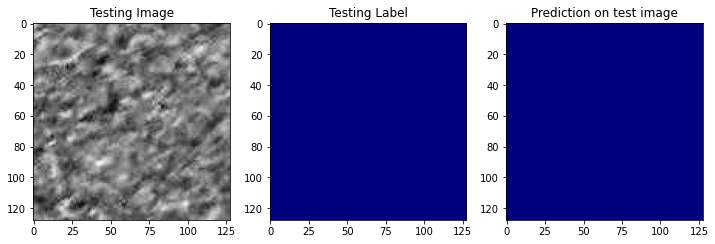

In [27]:
import random

test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth = y_test[test_img_number]

print('Image number', test_img_number)


test_img_input=test_img[:,:,:][None, :,:]
print(test_img_input.shape)

prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')

plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')

plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='jet')

plt.show()

## Large Image Check

In [28]:
from patchify import patchify, unpatchify

img_file = 'data/train/img19.tiff'
mask_file = 'data/train_mask/img19_mask.tiff'
large_image = tiff.imread(img_file)
mask_image = tiff.imread(mask_file)
print('Original image size: ', large_image.shape)

patches = patchify(large_image, (128, 128, 3), step=128) 
print(patches.shape)

Original image size:  (1080, 1920, 3)
(8, 15, 1, 128, 128, 3)


In [29]:
predicted_patches = []

for i in range(patches.shape[0]):
    for j in range(patches.shape[1]):
        #print(i,j)
        single_patch = patches[i,j, 0, :, :, :]
        single_patch_norm = normalize(single_patch, axis=0)
        single_patch_norm_wtf = single_patch_norm[:,:,:][None, :,:]
        single_patch_prediction = model.predict(single_patch_norm_wtf)
        
        single_patch_predicted_img = np.argmax(single_patch_prediction, axis=3)[0,:,:]
        predicted_patches.append(single_patch_predicted_img)

predicted_patches = np.array(predicted_patches)
print(predicted_patches.shape)

(120, 128, 128)


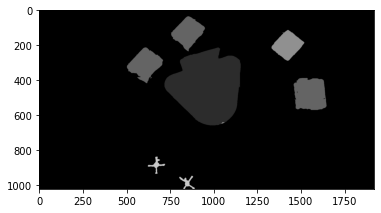

In [30]:
from PIL import Image

result = Image.new('P', (1920, 1024))

k = 0
for i in range(8):
    for j in range(15):
        PIL_image = Image.fromarray((predicted_patches[k] * 100).astype('uint8'), 'P')
        result.paste(PIL_image, (j*128, i*128))
        k += 1
        
plt.imsave('check_for_large_image.png',result, cmap='gray')
plt.imshow(result, cmap='gray')

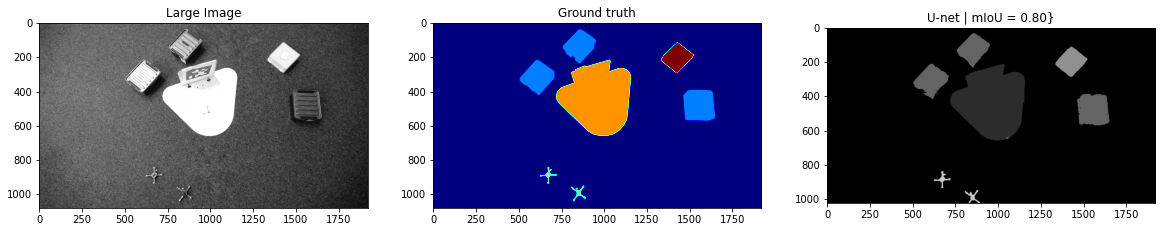

In [32]:
plt.figure(figsize=(20, 18))

plt.subplot(131)
plt.title('Large Image')
plt.imshow(large_image[:,:,0], cmap='gray')

plt.subplot(132)
plt.title('Ground truth')
plt.imshow(mask_image, cmap='jet')

plt.subplot(133)
plt.title('U-net | mIoU = 0.80}')
plt.imshow(result, cmap='jet')

fig.savefig('full_figure.png')
plt.imsave('result_for_unet3_resnet.png',result, cmap='gray')
plt.show()

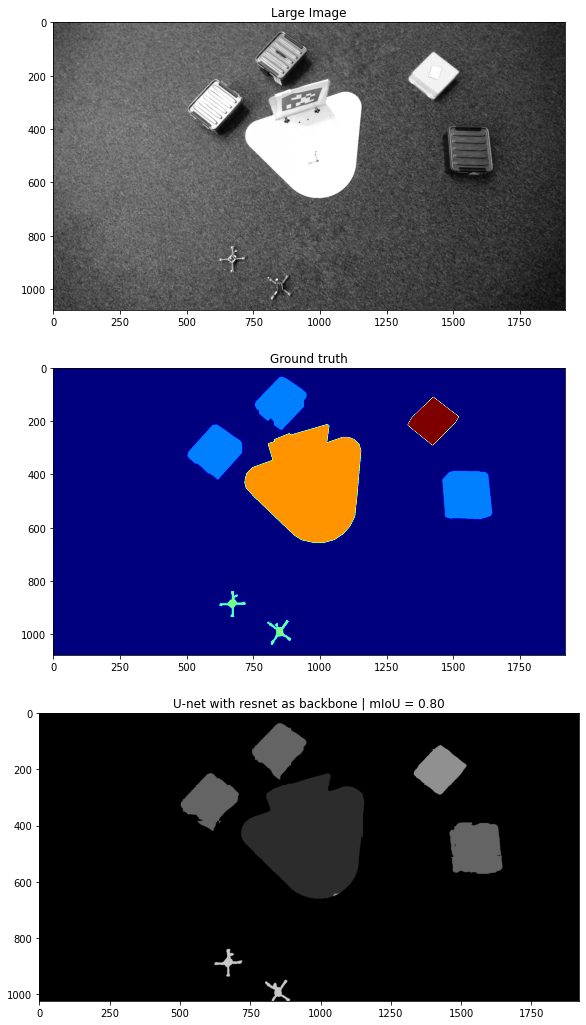

In [77]:
fig = plt.figure(figsize=(20, 18))
ax1 = fig.add_subplot(3,1,1)
ax1.set_title('Large Image')
ax1.imshow(large_image[:,:,0], cmap='gray')


ax2 = fig.add_subplot(3,1,2)
ax2.set_title('Ground truth')
ax2.imshow(mask_image, cmap='jet')

ax3 = fig.add_subplot(3,1,3)
ax3.set_title('U-net with resnet as backbone | mIoU = 0.80')
ax3.imshow(result, cmap='jet')


fig.savefig('result_for_unet3_resnet.png')

## Make results pretty

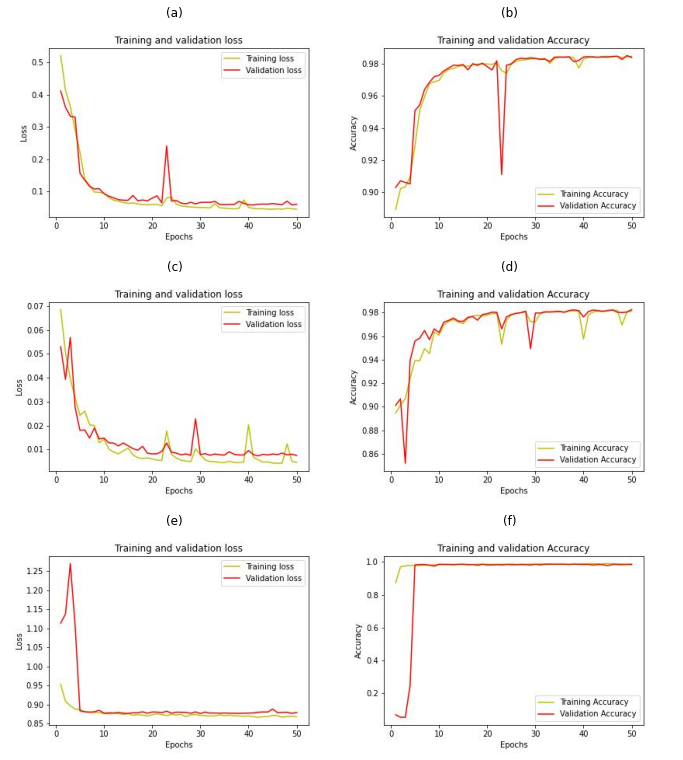

In [60]:
losses = ['test_50_epochs_8_batch_size_no_class_weights_loss.jpg',
    'test_50_epochs_8_batch_size_focal_loss_loss.jpg',
          'test_50_epochs_8_batch_size_resnet_unet_loss.jpg'
         ]

acc = [
              'test_50_epochs_8_batch_size_no_class_weights_accuracy.jpg',
    'test_50_epochs_8_batch_size_focal_loss_accuracy.jpg',
              'test_50_epochs_8_batch_size_resnet_unet_accuracy.jpg'    
]

im1 = plt.imread(losses[0])
im2 = plt.imread(losses[1])
im3 = plt.imread(losses[2])

im4 = plt.imread(acc[0])
im5 = plt.imread(acc[1])
im6 = plt.imread(acc[2])


fig = plt.figure(figsize=(12, 16))
ax1 = fig.add_subplot(3,2,1)
ax1.set_title('(a)')
ax1.set_axis_off()
ax1.imshow(im1)


ax2 = fig.add_subplot(3,2,3)
ax2.set_title('(c)')
ax2.set_axis_off()
ax2.imshow(im2)

ax3 = fig.add_subplot(3,2,5)
ax3.set_title('(e)')
ax3.set_axis_off()
ax3.imshow(im3,)


ax4 = fig.add_subplot(3,2,2)
ax4.set_title('(b)')
ax4.set_axis_off()
ax4.imshow(im4)


ax5 = fig.add_subplot(3,2,4)
ax5.set_title('(d)')
ax5.set_axis_off()
ax5.imshow(im5)

ax6 = fig.add_subplot(3,2,6)
ax6.set_title('(f)')
ax6.set_axis_off()
ax6.imshow(im6)

plt.subplots_adjust(wspace=0, hspace=-0.3)


fig.savefig('final_result.png')

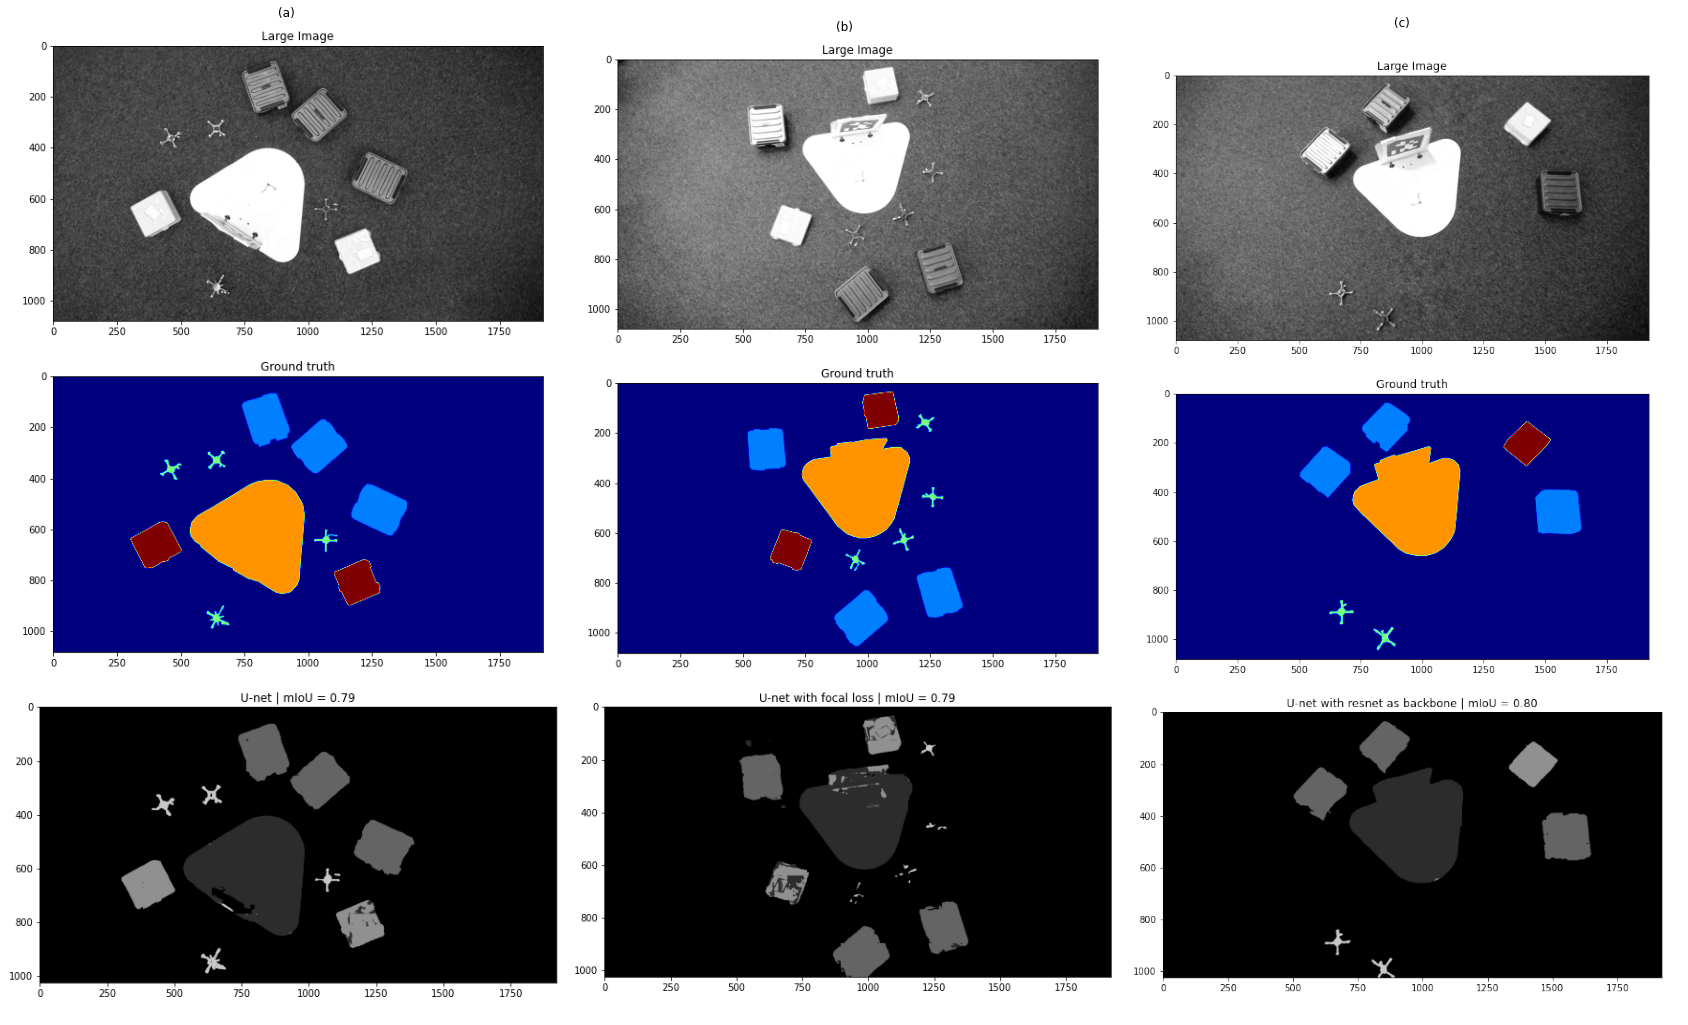

In [80]:
res = [
    'result_for_unet1_categorical_crossentropy.png',
'result_for_unet2_focal_loss.png',
'result_for_unet3_resnet.png'    ,
]

im1 = plt.imread(res[0])
im2 = plt.imread(res[1])
im3 = plt.imread(res[2])


fig = plt.figure(figsize=(30, 26))
ax1 = fig.add_subplot(1,3,1)
ax1.set_title('(a)')
ax1.set_axis_off()
ax1.imshow(im1)


ax2 = fig.add_subplot(1,3,2)
ax2.set_title('(b)')
ax2.set_axis_off()
ax2.imshow(im2)

ax3 = fig.add_subplot(1,3,3)
ax3.set_title('(c)')
ax3.set_axis_off()
ax3.imshow(im3,)


plt.subplots_adjust(wspace=0, hspace=0)


fig.savefig('final_results_for_3_models.png')